# **Welcome to Netflix Movies and TV Shows Analysis**
###### Project by Louisa Veronica

### **Business Understanding**
Perusahaan bernama Netflix merupakah perusahaan yang menayangkan film dan TV show berbasis subcription berbayar kepada pelanggannya. Perusahaan ingin mempermudah pelanggan dengan memberikan rekomendasi film atau TV show.


### **Preliminary**
*   Objective Statement:
    *   Mendapatkan business insight untuk mengetahui detail film dan TV show yang ditayangkan di Netflix
    *   Mendapatkan business insight dengan menjawab pertanyaan sebagai berikut:
        1. Seberapa updatekah film dan TV show yang terdapat pada Netflix?
        2. Genre film dan TV show apa yang dirilis di Netflix pada 3 tahun terakhir?
    
*   Challenges:
    *   Jumlah data yang besar
    *   Adanya missing value
    *   Adanya kolom dengan tipe data atau value yang tidak sesuai
    *   Kurangnya informasi yang dapat membantu untuk membuat rekomendasi film atau TV show
   
*   Methodology/Analytic Technique:
    *   Exploratory Data Analysis
    *   Deep-Dive Exploration
    *   TF-IDF (Term Frequency - Inverse Document Frequency)
    *   Cosine Similarity

*   Business Benefit:
    *   Memberikan rekomendasi film atau TV show kepada pelanggan, sehingga pelanggan tertarik untuk terus berlangganan Netflix

*   Expected Outcomes: 
    * Mengetahui detail film dan TV show yang ditayangkan di Netflix
    * Membuat machine learning yang dapat memberikan rekomendasi film atau TV show


### **Data Understanding**
*   Sumber data: Netflix Movies and TV Shows yang berasal dari Kaggle, yang dapat diakses melalui link sebagai berikut:
https://www.kaggle.com/datasets/shivamb/netflix-shows

*   Data detail:
    *   show_id: ID tayangan
    *   type: apakah tayangan termasuk movie atau TV show
    *   title: judul film atau TV show
    *   director: direktur film
    *   cast: pemeran film atau TV show
    *   country: negara di mana film atau TV show diproduksi
    *   date_added: tanggal release film atau TV show di Netflix
    *   release_year: tahun release film atau TV show yang sebenarnya
    *   rating: rating atas film atau TV show
    *   duration: total durasi dalam menit atau jumlah season
    *   listed_in: genre atas film atau TV show 
    *   description: rangkuman deskripsi film atau TV show



### **Data Preparation**

#### Import Package

In [1]:
#Import Warning
import warnings
warnings.filterwarnings('ignore')

#Import Package yang Digunakan
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#### Load Dataset

In [2]:
#Upload Data
df = pd.read_csv("/content/netflix_titles.csv")
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [3]:
#Melihat Informasi Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Observation:
1. Data memiliki 12 kolom dengan 8807 baris
2. Terdapat 11 kolom yang bertipe data Categorical, 1 kolom yang bertipe data Numerical
3. Kolom date_added memiliki tipe data yang tidak sesuai yang harus diproses lebih lanjut
4. Terdapat indikasi adanya missing value karena beberapa kolom memiliki jumlah data yang berbeda dengan jumlah total baris

### **Pre-Processing**

In [4]:
#Melihat Isi Data untuk show_id
df["show_id"].value_counts

<bound method IndexOpsMixin.value_counts of 0          s1
1          s2
2          s3
3          s4
4          s5
        ...  
8802    s8803
8803    s8804
8804    s8805
8805    s8806
8806    s8807
Name: show_id, Length: 8807, dtype: object>

Observation:
1. Kolom show_id berisikan nomor ID atas masing-masing film dan TV show, sehingga tidak bermanfaat dalam analisa dan dapat didrop kolom

In [5]:
#Mendrop Kolom show_id
df=df.drop(columns="show_id")

In [6]:
#Melihat Isi Data untuk date_added karena Memiliki Tipe Data yang Kurang Sesuai
df["date_added"].value_counts()

January 1, 2020      109
November 1, 2019      89
March 1, 2018         75
December 31, 2019     74
October 1, 2018       71
                    ... 
December 4, 2016       1
November 21, 2016      1
November 19, 2016      1
November 17, 2016      1
January 11, 2020       1
Name: date_added, Length: 1767, dtype: int64

Observation:
1. Kolom date_added berisikan tanggal dengan format month, day, year, sehingga dapat displit menjadi month_added dan year_added untuk mempermudah analisa, sedangkan untuk day dapat dihilangkan karena tidak dibutuhkan untuk menganalisa secara detail
2. Setelah mensplit kolom date_added, kolom date_added dapat didrop kolom agar tidak terdapat duplikasi kolom

In [7]:
#Mengubah Tipe Data date_added
df["date_added"] = pd.to_datetime(df["date_added"])

#Mensplit date_added
df["month_added"] = df["date_added"].dt.month.astype("Int64")
df["year_added"] = df["date_added"].dt.year.astype("Int64")

#Mendrop date_added agar Tidak Duplikasi dengan Kolom yang Displit di Atas
df=df.drop(columns="date_added")

#Mengecek Ulang Isi Data
df.head(3)

,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,2021
1,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,2021
2,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,2021


In [8]:
#Mengecek Ulang Tipe Data Setelah Pemrosesan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          8807 non-null   object
 1   title         8807 non-null   object
 2   director      6173 non-null   object
 3   cast          7982 non-null   object
 4   country       7976 non-null   object
 5   release_year  8807 non-null   int64 
 6   rating        8803 non-null   object
 7   duration      8804 non-null   object
 8   listed_in     8807 non-null   object
 9   description   8807 non-null   object
 10  month_added   8797 non-null   Int64 
 11  year_added    8797 non-null   Int64 
dtypes: Int64(2), int64(1), object(9)
memory usage: 843.0+ KB


Observation:
1. Data memiliki 12 kolom dengan 8807 baris
2. Terdapat 10 kolom yang bertipe data Categorical, 2 kolom yang bertipe data Numerical
3. Data terlihat memiliki tipe data yang sesuai dengan kolomnya
4. Terdapat indikasi adanya missing value karena beberapa kolom memiliki jumlah data yang berbeda dengan jumlah total baris

### **Perform Standard Data Cleaning**

####**Missing Value**

In [9]:
#Mengecek Adanya Missing Value
df.isna().sum()

type               0
title              0
director        2634
cast             825
country          831
release_year       0
rating             4
duration           3
listed_in          0
description        0
month_added       10
year_added        10
dtype: int64

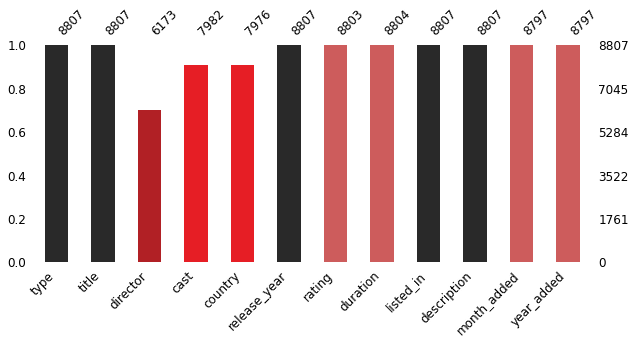

In [10]:
color = ["#292929","#292929","#B12025","#E61E25","#E61E25","#292929","indianred","indianred","#292929","#292929","indianred","indianred"]
missingno.bar(df,fontsize =12, color = color, figsize = (10,4))
plt.show()

Observation:
1. Sesuai dengan observation di atas, data memiliki missing value yang harus dihandle, sebagai berikut:
   *   director : replace blank dengan "No Director"
   *   cast : replace blank dengan "No Cast"
   *   country : replace dengan "United States" karena kebanyakan film atau TV shows yang terdapat di Netflix berasal dari United States
   *   rating : replace dengan modus
   *   duration : replace dengan modus
   *   month_added : replace dengan modus
   *   year_added : replace dengan modus

Sebagai tambahan, kita tidak dapat meremove row karena kita ingin untuk membuat recommendation system pada akhir project, sehingga tidak ingin kehilangan judul film atau TV shows apapun


In [11]:
#Mereplace Blank pada director
df["director"]=df["director"].fillna("No Director")

#Mereplace Blank pada cast
df["cast"]=df["cast"].fillna(" No Cast")

#Mereplace Blank pada country
df["country"]=df["country"].fillna("No Country")

#Mereplace Blank pada rating
df["rating"]=df["rating"].fillna(df["rating"].mode()[0])

#Mereplace Blank pada duration
df["duration"]=df["duration"].fillna(df["duration"].mode()[0])

#Mereplace Blank pada month_added
df["month_added"]=df["month_added"].fillna(df["month_added"].mode()[0])

#Mereplace Blank pada year_added
df["year_added"]=df["year_added"].fillna(df["year_added"].mode()[0])

In [12]:
#Mengecek Ulang Adanya Missing Value
df.isna().sum()

type            0
title           0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
month_added     0
year_added      0
dtype: int64

In [13]:
#Mengecek Ulang Dimensi Data Setelah Mentreatment Missing Value
df.shape

(8807, 12)

In [14]:
#Mengecek Ulang Isi Data Setelah Mentreatment Missing Value
df.head(3)

,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Cast,United States,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,2021
1,TV Show,Blood & Water,No Director,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,2021
2,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Country,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,2021


Observation:
1. Missing value telah dihandle, sehingga tidak terdapat lagi adanya missing value

####**Duplicate**

In [15]:
#Mengecek Adanya Duplikat Data
df.duplicated().sum()

0

Observation:
1. Data tidak memiliki duplicate

### **Perform Standard EDA with Rich Interpretations**

#### **Univariate / Bivariate / Multivariate Analysis**

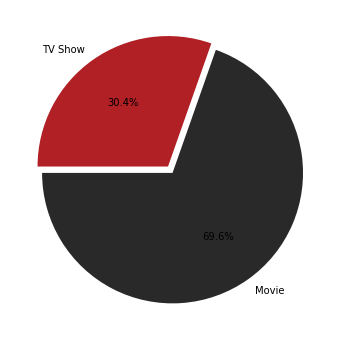

In [16]:
#Membuat Bar Plot untuk Melihat Jenis Tayangan
color=["#292929","#B12025"]
plt.figure(figsize=(8,6))
plt.pie(df.type.value_counts(), explode=(0.03,0.03), labels=df.type.value_counts().index, colors=color, autopct="%1.1f%%", startangle=180)
plt.show()

Observation:
1. Sebanyak 69.6% tayangan pada Netflix adalah film, sedangkan 30.4% berupa TV show. Hal ini dikarenakan masih belum banyaknya tayangan original yang diproduksi sendiri oleh Netflix, sehingga Netflix lebih banyak bergantung pada tayangan yang diproduksi oleh kompetitor, dimana kompetitor tersebut mempunyai channel tersendiri untuk menayangkannya.
2. Kolom type dapat digunakan untuk menggroupkan data, sehingga dapat membantu untuk menganalisa data lebih dalam


In [17]:
#Menggroupkan Data Berdasarkan type
Moviedf = df[df["type"] == "Movie"]
TVdf = df[df["type"] == "TV Show"]

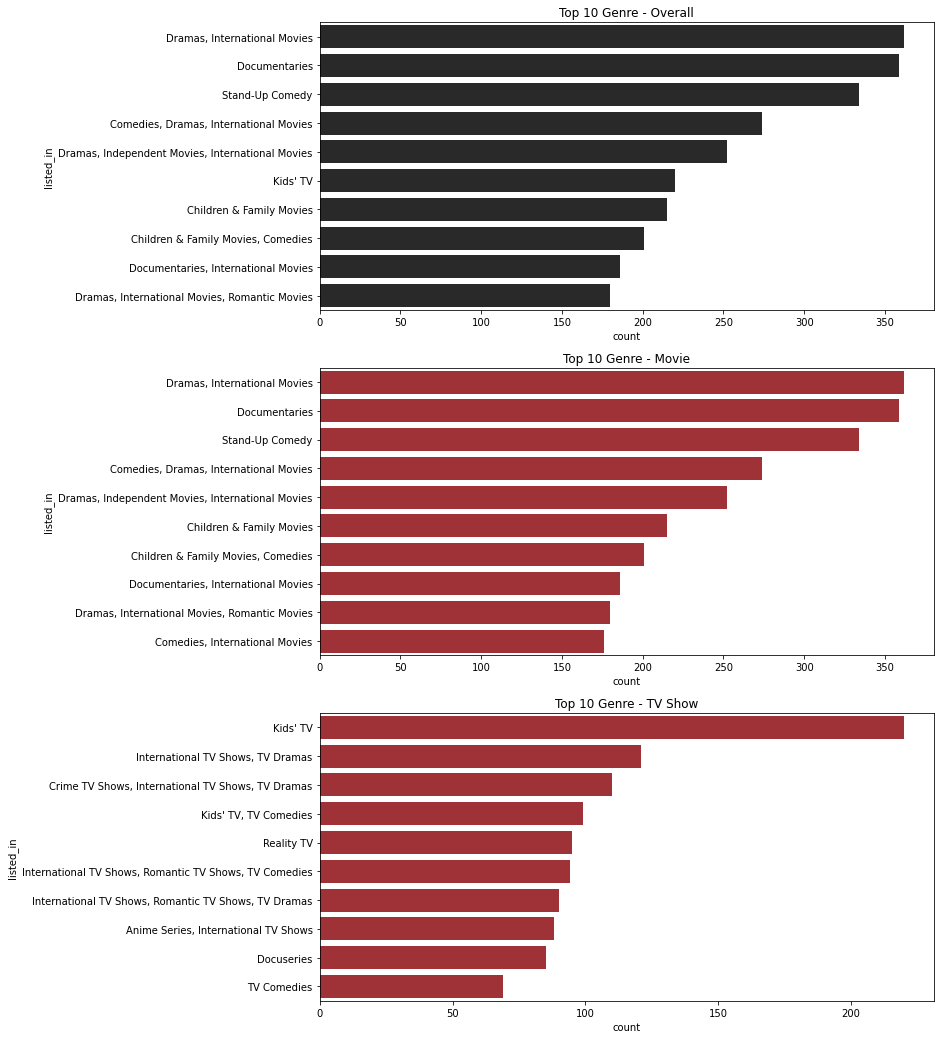

In [18]:
#Membuat Subplot untuk Melihat Top 10 genre
fig, ax = plt.subplots(3,1,figsize=(11,18))

#Membuat Bar Plot untuk Melihat Top 10 genre Secara Keseluruhan
sns.countplot(data=df,y="listed_in",order=df["listed_in"].value_counts().index[0:10],color="#292929",ax=ax[0])
ax[0].title.set_text("Top 10 Genre - Overall")

#Membuat Bar Plot untuk Melihat Top 10 genre Berdasarkan Movie
sns.countplot(data=Moviedf,y="listed_in",order=Moviedf["listed_in"].value_counts().index[0:10],color="#B12025",ax=ax[1])
ax[1].title.set_text("Top 10 Genre - Movie")

#Membuat Bar Plot untuk Melihat Top 10 genre Berdasarkan TV Show
sns.countplot(data=TVdf,y="listed_in",order=TVdf["listed_in"].value_counts().index[0:10],color="#B12025",ax=ax[2])
ax[2].title.set_text("Top 10 Genre - TV Show")

Observation:
1. Top 3 genre yang terdapat pada Netflix secara keseluruhan adalah Dramas, International Movies dan Documentaries yang berjumlah hampir sama, yaitu 350 untuk masing-masing, serta Stand Up Comedy yang berjumlah tidak jauh berbeda dari top 1 dan 2
2. Karena kebanyakan jenis tayangan yang terdapat pada Netflix adalah Movie, maka top 3 genre pada Movie sama persis dengan top 3 yang terdapat pada data secara keseluruhan
3. Untuk TV show, lebih dari 200 tayangan adalah Kids TV
4. Seperti yang telah disebutkan di atas, kebanyakan tayangan di Netflix bukan merupakan tayangan original yang diproduksi oleh Netflix. Sejalan dengan hal ini, berdasarkan genrenya, tayangan yang tersedia adalah tayangan dengan harga lisensi yang murah, seperti Dramas/Internasional Movies dan Documentaries ataupun Kids TV


In [19]:
#Mengecek Value dari Rating karena Apabila Divisualisasikan terdapat Value yang Tidak Sesuai
df["rating"].value_counts()

TV-MA       3211
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [20]:
#Melihat Isi Data untuk rating yang Tidak Sesuai
df.loc[((df["rating"]=="74 min")|(df["rating"]=="84 min")|(df["rating"]=="66 min")),["rating","type","description"]]

,rating,type,description
5541,74 min,Movie,"Louis C.K. muses on religion, eternal love, gi..."
5794,84 min,Movie,Emmy-winning comedy writer Louis C.K. brings h...
5813,66 min,Movie,The comic puts his trademark hilarious/thought...


Observation:
1. Terdapat isi data yang tidak sesuai yang seharusnya berupa duration dan berdasarkan descriptionnya dapat dikategorikan sebagai:
     *  74 min : NC-17
     *  84 min : NC-17
     *  66 min NC-17

In [21]:
#Mereplace Value untuk rating yang Tidak Sesuai
df["rating"].replace("74 min","NC-17",inplace=True)
df["rating"].replace("84 min","NC-17",inplace=True)
df["rating"].replace("66 min","NC-17",inplace=True)

Moviedf["rating"].replace("74 min","NC-17",inplace=True)
Moviedf["rating"].replace("84 min","NC-17",inplace=True)
Moviedf["rating"].replace("66 min","NC-17",inplace=True)

#Mengecek Ulang Value rating Setelah Direplace
df["rating"].value_counts()

TV-MA       3211
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
NC-17          6
TV-Y7-FV       6
UR             3
Name: rating, dtype: int64

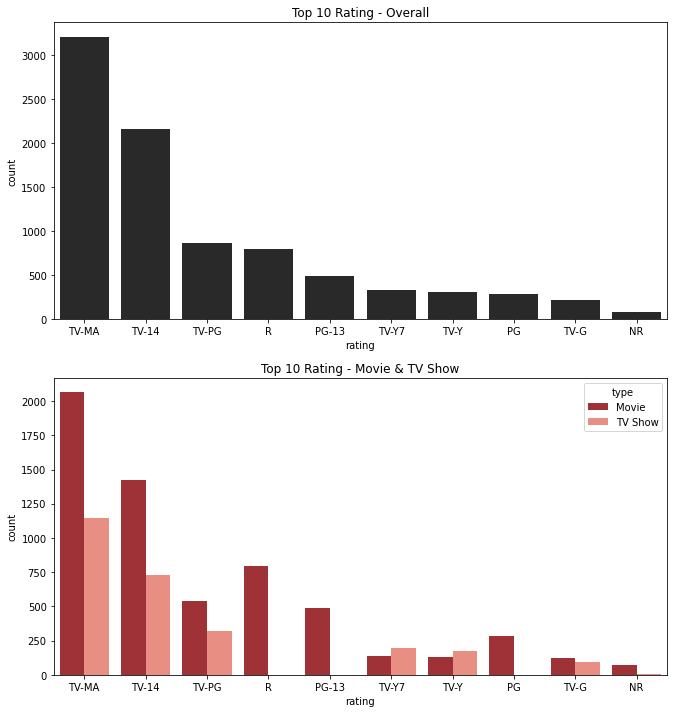

In [22]:
#Membuat Subplot untuk Melihat Top 10 rating
fig, ax = plt.subplots(2,1,figsize=(11,12))

#Membuat Bar Plot untuk Melihat rating Secara Keseluruhan
sns.countplot(data=df,x="rating",order=df["rating"].value_counts().index[0:10],color="#292929",ax=ax[0])
ax[0].title.set_text("Top 10 Rating - Overall")

#Membuat Bar Plot untuk Melihat rating Berdasarkan Movie dan TV Show
sns.countplot(data=df,x="rating",order=df["rating"].value_counts().index[0:10],hue="type",palette=["#B12025","salmon"],ax=ax[1])
ax[1].title.set_text("Top 10 Rating - Movie & TV Show")

Observation:
1. Berdasarkan ratingnya, kebanyakan film Netflix merupakan tayangan dengan rating TV-MA, yaitu rating untuk TV show bagi dewasa atau berusia 17 tahun ke atas dan disusul dengan rating TV-14, yaitu rating untuk TV show bagi remaja berusia 14 tahun ke atas
2. Sama halnya untuk Movie dan TV Show, dimana top 2 rating juga adalah TV-MA dan TV-14. Namun, untuk top 3 pada Movie adalah R, yaitu rating untuk dewasa, sedangkan pada TV show adalah TV-PG, yaitu untuk anak di bawah 13 tahun
3. Dapat dilihat secara keseluruhan, rating untuk Movie banyak didominasi untuk dewasa, sedangkan TV show memiliki lebih banyak konten untuk semua umur, mulai dari anak hingga dewasa

In [23]:
#Mengecek Value dari duration karena Apabila Divisualisasikan terdapat Kata Berarti Sama tetapi Ditulis Berbeda
df["duration"].value_counts()

1 Season     1796
2 Seasons     425
3 Seasons     199
90 min        152
94 min        146
             ... 
16 min          1
186 min         1
193 min         1
189 min         1
191 min         1
Name: duration, Length: 220, dtype: int64

In [24]:
#Mereplace Value untuk duration yang Tidak Sesuai
df["duration"]=df["duration"].str.replace("Seasons","season")
df["duration"]=df["duration"].str.replace("Season","season")
TVdf["duration"]=TVdf["duration"].str.replace("Seasons","season")
TVdf["duration"]=TVdf["duration"].str.replace("Season","season")

#Mengecek Ulang Value rating Setelah Direplace
df["duration"].value_counts()
TVdf["duration"].value_counts()

1 season     1793
2 season      425
3 season      199
4 season       95
5 season       65
6 season       33
7 season       23
8 season       17
9 season        9
10 season       7
13 season       3
15 season       2
12 season       2
11 season       2
17 season       1
Name: duration, dtype: int64

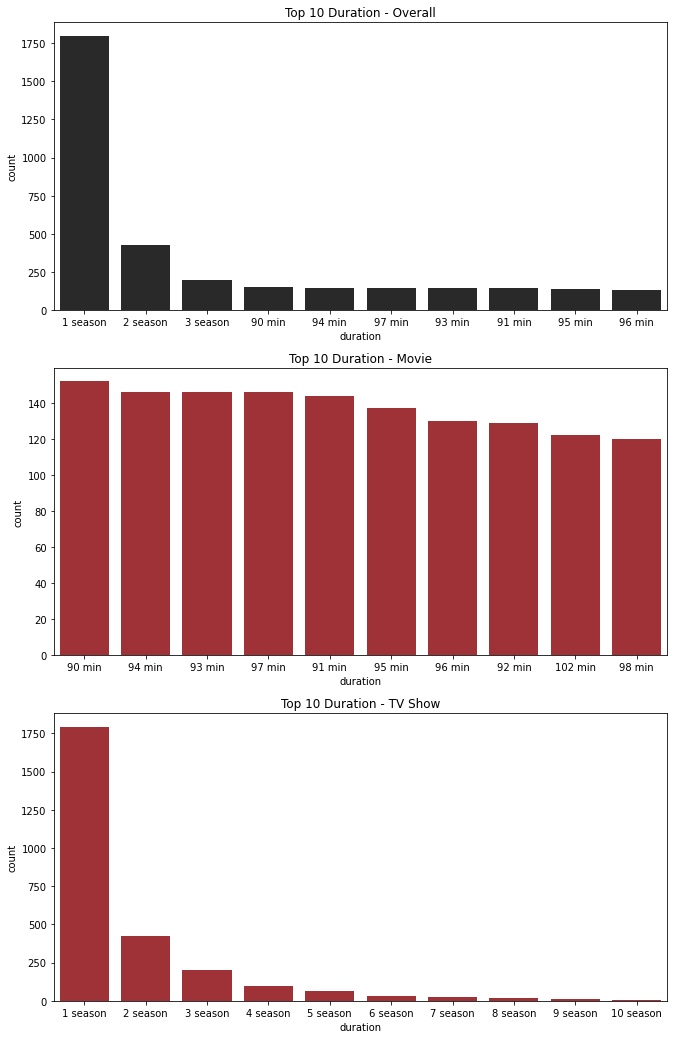

In [25]:
#Membuat Subplot untuk Melihat Top 10 duration
fig, ax = plt.subplots(3,1,figsize=(11,18))

#Membuat Bar Plot untuk Melihat duration Secara Keseluruhan
sns.countplot(data=df,x="duration",order=df["duration"].value_counts().index[0:10],color="#292929",ax=ax[0])
ax[0].title.set_text("Top 10 Duration - Overall")

#Membuat Bar Plot untuk Melihat duration Berdasarkan Movie
sns.countplot(data=Moviedf,x="duration",order=Moviedf["duration"].value_counts().index[0:10],color="#B12025",ax=ax[1])
ax[1].title.set_text("Top 10 Duration - Movie")

#Membuat Bar Plot untuk Melihat duration Berdasarkan TV Show
sns.countplot(data=TVdf,x="duration",order=TVdf["duration"].value_counts().index[0:10],color="#B12025",ax=ax[2])
ax[2].title.set_text("Top 10 Duration - TV Show")

Observation:
1. Berdasarkan durasinya, secara keseluruhan, terdapat kurang lebih 1750 merupakan TV show berdurasi 1 season dan rata-rata film berdurasi 90 an menit
2. Apabila fokus pada Movie saja, rata-rata film benar berdurasi kurang lebih 90 menit - 102 menit. 
3. Untuk TV show, juga didominasi oleh TV show berdurasi 1 season dan sangat jarang ada TV show yang berdurasi di atas 5 season. Hal ini kemungkinan disebabkan oleh Netflix yang mencoba untuk menayangkan berbagai macam TV show untuk melihat respon pelanggan terlebih dahulu. Namun, TV show tersebut kurang diminati oleh pelanggannya atau kurangnya biaya untuk memproduksi TV show lanjutan, sehingga dihentikan penayangannya

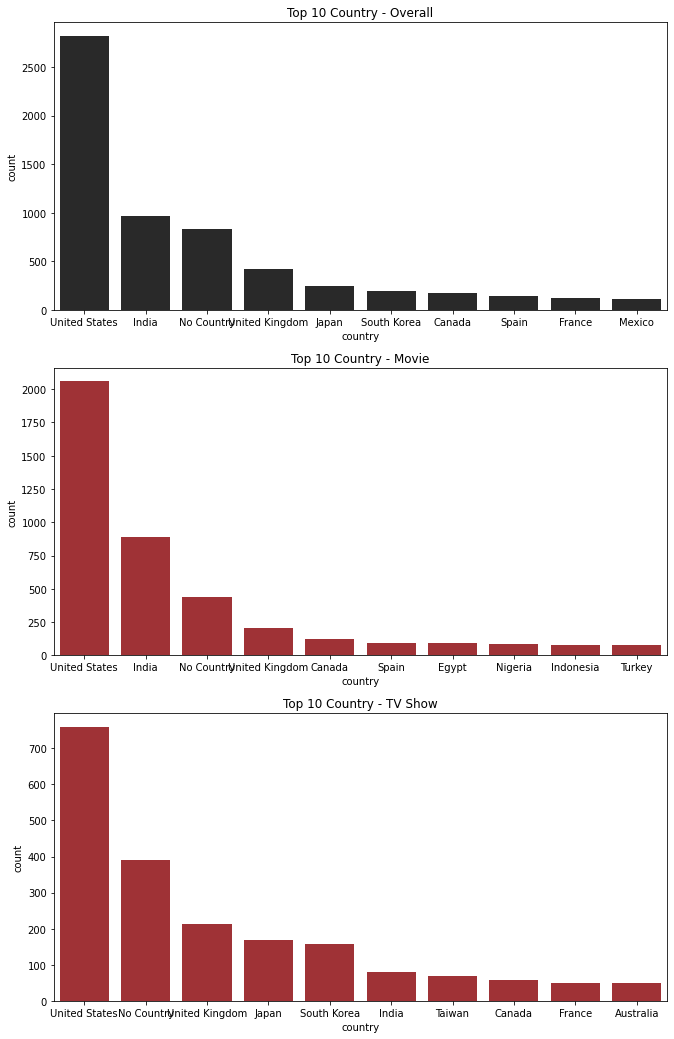

In [26]:
#Membuat Subplot untuk Melihat Top 10 country
fig, ax = plt.subplots(3,1,figsize=(11,18))

#Membuat Bar Plot untuk Melihat country Secara Keseluruhan
sns.countplot(data=df,x="country",order=df["country"].value_counts().index[0:10],color="#292929",ax=ax[0])
ax[0].title.set_text("Top 10 Country - Overall")

#Membuat Bar Plot untuk Melihat country Berdasarkan Movie
sns.countplot(data=Moviedf,x="country",order=Moviedf["country"].value_counts().index[0:10],color="#B12025",ax=ax[1])
ax[1].title.set_text("Top 10 Country - Movie")

#Membuat Bar Plot untuk Melihat country Berdasarkan TV Show
sns.countplot(data=TVdf,x="country",order=TVdf["country"].value_counts().index[0:10],color="#B12025",ax=ax[2])
ax[2].title.set_text("Top 10 Country - TV Show")

Observation:
1. Terlihat bahwa kebanyakan film ataupun TV show merupakan produksi dari United States, yang memang terkenal untuk dunia perfilman dan pertelevisiannya.
2. Jika melihat lebih dalam, India terkenal dalam dunia perfilman Bollywood, sehingga menjadi top 2 untuk kategori film. Namun, India masih kurang dalam dunia TV show bila dibandingkan dengan United Kingdom yang merupakan top 2 dalam kategori TV show.

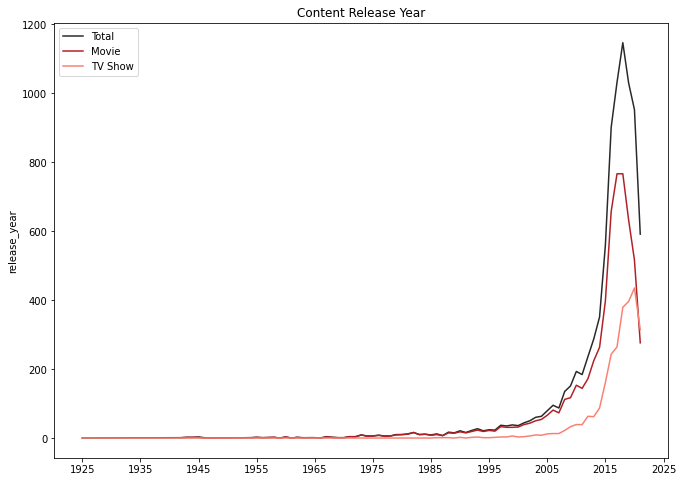

In [27]:
#Mendefinisikan Nilai release_year pada Masing-Masing Dataframe yang Sudah Dipisah
release_df = df["release_year"].value_counts()
release_movie = Moviedf["release_year"].value_counts()
release_tv = TVdf["release_year"].value_counts()

#Membuat Subplot untuk Melihat release_year
fig, ax = plt.subplots(figsize=(11, 8))

#Membuat Line Plot untuk Melihat release_year Secara Keseluruhan
sns.lineplot(release_df.index, release_df,color="#292929")

#Membuat Line Plot untuk Melihat release_year Berdasarkan Movie
sns.lineplot(release_movie.index, release_movie,color="#B12025")

#Membuat Line Plot untuk Melihat release_year Berdasarkan TV Show
sns.lineplot(release_tv.index, release_tv,color="salmon")

#Mengatur Detail
ax.set_xticks(np.arange(1925, 2035, 10))
plt.title("Content Release Year")
plt.legend(["Total","Movie","TV Show"])

plt.show()

Observation:
1. TV show tertua yang ditayangkan di Netflix adalah TV show yang dirilis tahun 1925, sedangkan film tertua yang ditayangkan di Netflix adalah film yang dirilis sejak tahun 1940 an
2. Dunia perfilman dan TV show mulai meningkat tahun 2000 an dan semakin pesat sejak tahun 2015. Puncak dunia film berada di tahun 2017 - 2018 dan kemudian mulai menurun sejak tahun 2019 hingga 2021, sedangkan pada dunia TV show masih terus merangkat naik hingga tahun 2020 sebagai puncaknya dan menurun pada tahun 2021. Hal ini kemungkinan disebabkan oleh pandemi Covid-19 yang membatasi aktivitas manusia, sehingga kemungkinan lebih sulit untuk memproduksi film yang berskala besar dibandingkan dengan TV show yang berskala lebih kecil

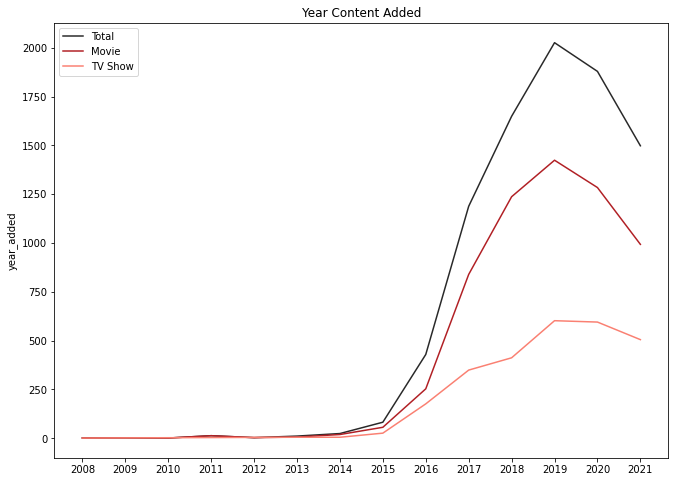

In [28]:
#Mendefinisikan Nilai year_added pada Masing-Masing Dataframe yang Sudah Dipisah
year_df = df["year_added"].value_counts()
year_movie = Moviedf["year_added"].value_counts()
year_tv = TVdf["year_added"].value_counts()

#Membuat Subplot untuk Melihat year_added
fig, ax = plt.subplots(figsize=(11, 8))

#Membuat Line Plot untuk Melihat year_added Secara Keseluruhan
sns.lineplot(year_df.index, year_df,color="#292929")

#Membuat Line Plot untuk Melihat year_added Berdasarkan Movie
sns.lineplot(year_movie.index, year_movie,color="#B12025")

#Membuat Line Plot untuk Melihat year_added Berdasarkan TV Show
sns.lineplot(year_tv.index, year_tv,color="salmon")

#Mengatur Detail
ax.set_xticks(np.arange(2008, 2022, 1))
plt.title("Year Content Added")
plt.legend(["Total","Movie","TV Show"])

plt.show()

Observation:
1. Netflix mulai merelease film atau TV show pada platformnya sejak tahun 2008, yang mana merupakan tahun berdirinya Netflix, dan sejalan dengan semakin majunya dunia film dan TV show yang mulai merangkak naik di tahun 2015, Netflix pun terus menambahkan film dan TV show pada platformnya hingga tahun 2019 sebagai puncaknya, kemudian menurun akibat pandemi Covid-19 pada tahun 2020 dan 2021
2. Selain itu, juga dapat disebabkan adanya competitor Netflix yang mulai bermunculan semenjak adanya pandemi Covid-19, seperti DisneyPlus dan Four Marvel yang menghentikan penayangannya di Netflix

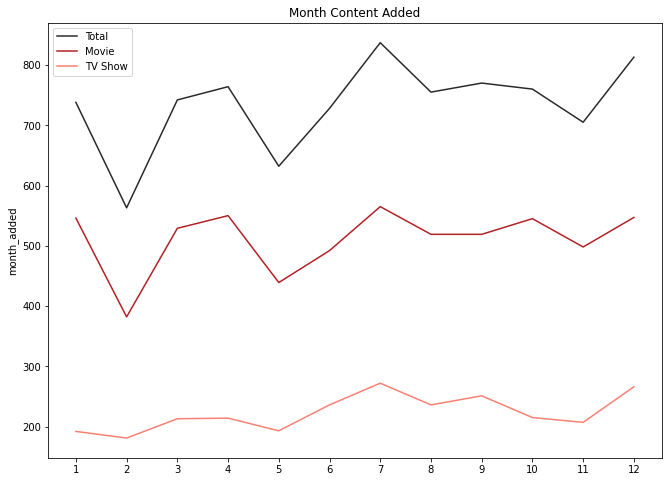

In [29]:
#Mendefinisikan Nilai month_added pada Masing-Masing Dataframe yang Sudah Dipisah
month_df = df["month_added"].value_counts()
month_movie = Moviedf["month_added"].value_counts()
month_tv = TVdf["month_added"].value_counts()

#Membuat Subplot untuk Melihat month_added
fig, ax = plt.subplots(figsize=(11, 8))

#Membuat Line Plot untuk Melihat month_added Secara Keseluruhan
sns.lineplot(month_df.index, month_df,color="#292929")

#Membuat Line Plot untuk Melihat month_added Berdasarkan Movie
sns.lineplot(month_movie.index, month_movie,color="#B12025")

#Membuat Line Plot untuk Melihat month_added Berdasarkan TV Show
sns.lineplot(month_tv.index, month_tv,color="salmon")

#Mengatur Detail
ax.set_xticks(np.arange(1, 13, 1))
plt.title("Month Content Added")
plt.legend(["Total","Movie","TV Show"])

plt.show()

Observation:
1. Jika melihat pada grafik tersebut, Netflix merilis film atau TV show dengan menyesuaikan pada jadwal holiday yang ada di US. Bulan July merupakan bulan dimana Netflix banyak merilis film atau TV show baru. Hal ini sejalan dengan puncak dari school holiday, yaitu summer break, dimana secara bervariasi, student akan libur selama 10 - 11 minggu mulai dari May atau June hingga August atau September. Selain itu, pada bulan December, yang juga merupakan school holiday, yaitu winter break, dan termasuk public holiday untuk orang yang bekerja, Netflix juga banyak merilis film atau TV show. Terlihat juga peningkatan pada bulan Maret, yang merupakan spring break untuk student selama 1 minggu. Sebaliknya, pada bulan di luar hari libur tersebut, Netflix lebih sedikit merilis film atau TV show baru

###Deep Dive Exploration

#####**Seberapa updatekah film dan TV show yang terdapat pada Netflix?**

In [30]:
#Menambahkan Kolom Baru untuk Melihat Selisih Tahun pada Movie
Moviedf["different"] = Moviedf["year_added"]-Moviedf["release_year"]
Moviedf[["release_year","year_added","different"]].head(5)

,release_year,year_added,different
0,2020,2021,1
6,2021,2021,0
7,1993,2021,28
9,2021,2021,0
12,2021,2021,0


In [31]:
#Menambahkan Kolom Baru untuk Melihat Selisih Tahun pada TV Show
TVdf["different"] = TVdf["year_added"]-TVdf["release_year"]
TVdf[["release_year","year_added","different"]].head(5)

,release_year,year_added,different
1,2021,2021,0
2,2021,2021,0
3,2021,2021,0
4,2021,2021,0
5,2021,2021,0


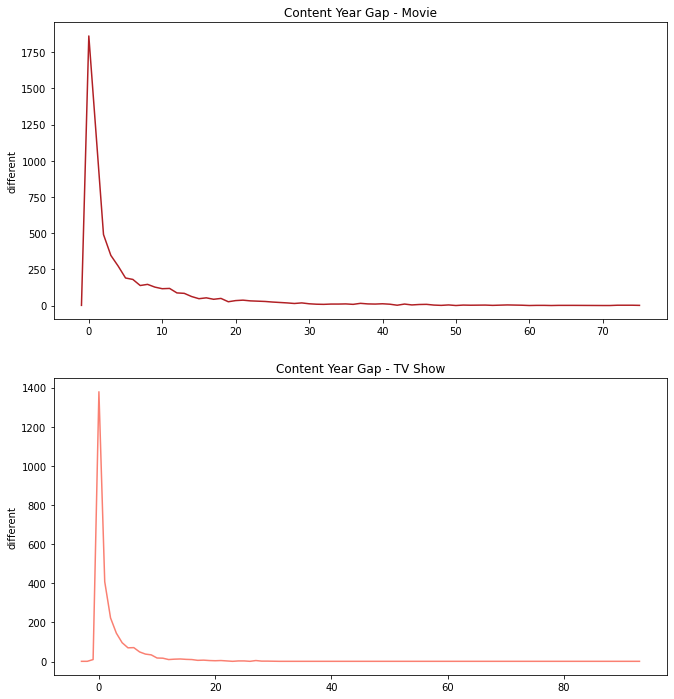

In [32]:
#Mendefinisikan Nilai year_added pada Masing-Masing Dataframe yang Sudah Dipisah
different_movie = Moviedf["different"].value_counts()
different_tv = TVdf["different"].value_counts()

#Membuat Subplot untuk Melihat year_added
fig, ax = plt.subplots(2,1,figsize=(11,12))

#Membuat Line Plot untuk Melihat different Berdasarkan Movie
sns.lineplot(different_movie.index, different_movie,color="#B12025",ax=ax[0])
ax[0].title.set_text("Content Year Gap - Movie")

#Membuat Line Plot untuk Melihat different Berdasarkan Movie
sns.lineplot(different_tv.index, different_tv,color="salmon",ax=ax[1])
ax[1].title.set_text("Content Year Gap - TV Show")

Observation:
1. Jika melihat pada selisih tahun release film dan TV show yang aktual dibandingkan dengan tahun release di Netflix, kebanyakan adalah 0, yang berarti film dan TV show yang terdapat pada Netflix direlease pada tahun yang sama dengan tahun release aslinya. Dengan demikian, dapat disimpulkan bahwa film dan TV show Netflix cukup update, meski demikian karena keterbatasan data, tidak dapat melihat hingga ke dalam bulannya 

#####**Genre film dan TV show apa yang dirilis di Netflix pada 3 tahun terakhir?**

In [33]:
#Memfilter year_added Movie untuk 3 Tahun Terakhir
year3_movie=Moviedf.loc[((Moviedf["year_added"]==2019)|(Moviedf["year_added"]==2020)|(Moviedf["year_added"]==2021)),]
year3_movie.head(3)

,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added,different
0,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Cast,United States,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,2021,1
6,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",No Country,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,9,2021,0
7,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",9,2021,28


In [34]:
#Memfilter year_added Movie untuk 3 Tahun Terakhir
year3_tv=TVdf.loc[((TVdf["year_added"]==2019)|(TVdf["year_added"]==2020)|(TVdf["year_added"]==2021)),]
year3_tv.head(3)

,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added,different
1,TV Show,Blood & Water,No Director,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,TV-MA,2 season,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,2021,0
2,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Country,2021,TV-MA,1 season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,2021,0
3,TV Show,Jailbirds New Orleans,No Director,No Cast,No Country,2021,TV-MA,1 season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",9,2021,0


In [35]:
genre_movie = (year3_movie
                .groupby(["year_added","listed_in"])
                .agg(genre_mcount=("listed_in","count"))
                .reset_index()
                .sort_values(["year_added","genre_mcount"],ascending=False).groupby("year_added").head(5)
                .head(15)
                )
genre_movie

,year_added,listed_in,genre_mcount
459,2021,"Dramas, International Movies",60
417,2021,"Comedies, Dramas, International Movies",43
387,2021,Children & Family Movies,40
388,2021,"Children & Family Movies, Comedies",40
344,2021,Action & Adventure,39
300,2020,"Dramas, International Movies",76
254,2020,"Comedies, Dramas, International Movies",72
214,2020,Children & Family Movies,55
217,2020,"Children & Family Movies, Comedies",54
303,2020,"Dramas, International Movies, Romantic Movies",51


Observation:
1. Terdapat perubahan film yang ditayangkan di Netflix pada tahun 2019 dengan tahun 2020 dan 2021. Tahun 2019, Netflix banyak memasukkan film documentaries yang kemungkinan disebabkan karena film tersebut memiliki biaya lisensi yang murah. Tahun 2020 dan 2021, ketika pandemi Covid-19 berdampak di seluruh dunia, Netflix banyak meraih pelanggan internasional, sehingga semakin banyak pula film-film international yang ditambahkan

In [36]:
genre_tv = (year3_tv
                .groupby(["year_added","listed_in"])
                .agg(genre_mcount=("listed_in","count"))
                .reset_index()
                .sort_values(["year_added","genre_mcount"],ascending=False).groupby("year_added").head(5)
                .head(15)
                )
genre_tv

,year_added,listed_in,genre_mcount
346,2021,Kids' TV,49
350,2021,"Kids' TV, TV Comedies",24
355,2021,Reality TV,22
329,2021,"International TV Shows, Romantic TV Shows, TV ...",21
340,2021,"International TV Shows, TV Dramas",19
222,2020,Kids' TV,44
234,2020,Reality TV,33
228,2020,"Kids' TV, TV Comedies",28
166,2020,"Crime TV Shows, International TV Shows, TV Dramas",26
133,2020,"Anime Series, International TV Shows",23


Observation:
1. Penambahan TV show pada Netflix masih didominasi oleh Kids TV, dimana tayangan untuk anak memang berlisensi lebih murah bila dibandingkan dengan tayangan berbau komedi misalnya

###**Recommendation System**

#####**Recommendation System Berdasarkan description**

In [37]:
#Memfilter description dengan TFIDF Vector - Stopword untuk Menyisakan Kata yang Penting saja
TFstop = TfidfVectorizer(stop_words = "english", lowercase = True)
TFmodel = TFstop.fit_transform(df["description"])

#Melihat Dimensi Data
TFmodel.shape

(8807, 18895)

In [38]:
#Membuat Cosine Similarity untuk Mengecek Kesamaan
Cosine = linear_kernel(TFmodel, TFmodel)

#Mengidentifikasi Index dari Judul yang Diberikan
ReturnIndex = pd.Series(df.index, index=df["title"]).drop_duplicates()

In [39]:
#Membuat Fungsi untuk Rekomendasi
def Recommendation1(Title, Cosine=Cosine):
    Index = ReturnIndex[Title]

    #Mencari Nilai Pairwise Similarity berdasarkan Title yang Diiput 
    Similarity = list(enumerate(Cosine[Index]))

    #Mengurutkan Title berdasarkan Nilai Cosine Similarity
    Similarity = sorted(Similarity, key=lambda x: x[1], reverse=True)

    #Memfilter untuk Mendapatkan Top 5 Movie
    Similarity = Similarity[1:6]
    ReturnMovie = [i[0] for i in Similarity]
    SimilarityMovie = [i[1] for i in Similarity]
    
    #Mereturn Fungsi
    return pd.DataFrame(zip(df["title"].iloc[ReturnMovie], SimilarityMovie), columns=["title","Similarity"])

In [40]:
Recommendation1("Naruto")

,title,Similarity
0,Naruto Shippuden: The Movie,0.258153
1,Naruto Shippuden the Movie: Blood Prison,0.229762
2,Naruto Shippuden : Blood Prison,0.229762
3,Sabrina,0.195734
4,Beyblade: Metal Fusion,0.187850


Observation:
1. Jika melihat pada rekomendasi yang dihasilkan berdasarkan description, terdapat 2 film yang kurang related dengan film yang diinputkan, sehingga kurang akurat. Oleh karena itu, akan dicoba untuk membuat model rekomendasi dengan menambahkan feature lainnya

#####**Recommendation System dengan Tambahan Feature Lainnya**

In [41]:
#Membuat Fungsi untuk Membersihkan Data
def Clean(text):
    #Mencocokkan Tipe Data dan Merapikan Data
    if isinstance(text, str):
        return str.lower(text.replace(" ", ""))
    else:
        return ""

In [42]:
#Memfilter Kolom Sesuai yang Dibutuhkan
filter=["title","director","cast","listed_in","description"]
Filterdf = df[filter]

In [43]:
#Mengaplikasikan Fungsi Clean pada Masing-Masing Kolom
Filterdf["title"]=Filterdf["title"].apply(Clean)
Filterdf["director"]=Filterdf["director"].apply(Clean)
Filterdf["cast"]=Filterdf["cast"].apply(Clean)
Filterdf["listed_in"]=Filterdf["listed_in"].apply(Clean)
Filterdf["description"]=Filterdf["description"].apply(Clean)

In [44]:
#Membuat Fungsi untuk Join Semua Feature Kecuali Title
features=["director","cast","listed_in","description"]
def Join(feature):
    #Menggabungkan Semua Feature
    return " ".join(str(feature[f]) for f in features)

In [45]:
#Mengaplikasikan Fungsi Join pada Feature yang Dipilih
Filterdf["Join"] = Filterdf.apply(Join, axis=1)

In [46]:
#Memfilter Feature dengan Count Vector - Stopword untuk Menyisakan Kata yang Penting saja
CVstop = CountVectorizer(stop_words = "english", lowercase = True)
CVmodel = CVstop.fit_transform(Filterdf["Join"])

#Melihat Dimensi Data
CVmodel.shape

(8807, 66746)

In [47]:
#Membuat Ulang Cosine Similarity untuk Mengecek Kesamaan
Cosine2 = cosine_similarity(CVmodel, CVmodel)
Filterdf.head(3)

,title,director,cast,listed_in,description,Join
0,dickjohnsonisdead,kirstenjohnson,nocast,documentaries,"asherfathernearstheendofhislife,filmmakerkirst...",kirstenjohnson nocast documentaries asherfathe...
1,blood&water,nodirector,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou...","nodirector amaqamata,khosingema,gailmabalane,t..."
2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille...","julienleclercq samibouajila,tracygotoas,samuel..."


In [48]:
#Mengidentifikasi Index dari Judul yang Diberikan
Filterdf = Filterdf.reset_index()
ReturnIndex = pd.Series(Filterdf.index, index=Filterdf["title"])

In [49]:
#Membuat Fungsi untuk Rekomendasi
def Recommendation2(Title, Cosine=Cosine):
    Title=Title.lower().replace(" ","")
    Index = ReturnIndex[Title]

    #Mencari Nilai Pairwise Similarity berdasarkan Title yang Diiput 
    Similarity = list(enumerate(Cosine[Index]))

    #Mengurutkan Title berdasarkan Nilai Cosine Similarity
    Similarity = sorted(Similarity, key=lambda x: x[1], reverse=True)

    #Memfilter untuk Mendapatkan Top 5 Movie
    Similarity = Similarity[1:6]
    ReturnMovie = [i[0] for i in Similarity]
    SimilarityMovie = [i[1] for i in Similarity]
    
    #Mereturn Fungsi
    return pd.DataFrame(zip(df["title"].iloc[ReturnMovie], SimilarityMovie), columns=["title","Similarity"])

In [51]:
Recommendation2("Naruto", Cosine2)

,title,Similarity
0,Naruto Shippûden the Movie: Bonds,0.302614
1,Naruto Shippuden the Movie: Blood Prison,0.269069
2,Naruto Shippuden : Blood Prison,0.269069
3,Naruto Shippûden the Movie: The Will of Fire,0.248069
4,Naruto the Movie: Ninja Clash in the Land of Snow,0.248069


Observation:
1. Jika melihat pada rekomendasi yang baru, hasilnya lebih sesuai dengan film yang diinputkan. Oleh karena itu, dengan semakin banyaknya feature, model dapat memberikan rekomendasi dengan semakin baik

### **Conclusion**
1. Terdapat beberapa masalah pada data, yaitu terdapat beberapa kolom yang berisikan missing value, terdapat value yang tidak sesuai dengan kolomnya, dan terdapat format yang berbeda - beda untuk beberapa value dalam 1 kolom. Namun, tidak terdapat duplicate ataupun outlier.
2. Untuk tipe data sendiri, data memiliki tipe data categorical dan numerical atau date. Kolom date perlu ditransformasi untuk dipisahkan menjadi bulan dan tahun, sehingga dapat membantu untuk analisa lebih lanjut.
3. Data dapat dikategorikan berdasarkan type menjadi Movie dan TV Show untuk membantu analisa lebih lanjut
4. Berdasarkan analisa di atas, dapat diketahui bahwa terdapat lebih banyak Movie daripada TV show di Netflix. Genre yang paling banyak untuk Movie adalah Drama, International Movies dan Documentary dengan durasi Movie paling populer berada pada 90 an menit, sedangkan untuk TV show didominasi oleh Kids TV dan durasi paling banyak hanya terbatas pada 1 season. Hal ini sejalan dengan rating dimana untuk Movie lebih banyak ditujukan untuk konten bagi dewasa dan TV show lebih banyak ditujukan untuk konten yang dapat dinikmati oleh semua umur, mulai dari anak hingga dewasa. Kebanyakan Movie dan TV show diproduksi di United States dan India, yang kebanyakan direlease secara resmi dan di Netflix pada tahun 2015 ke atas.
5. Hampir semua Movie dan TV Show di Netflix direlease pada tahun yang sama dengan tahun release aslinya, sehingga dapat disimpulkan bahwa Netflix mengikuti perkembangan terupdate dunia film dan TV Show.
6. Terdapat perubahan genre atas Movie yang ditambahkan ke Netflix dari Documentaries di tahun 2019 ke Dramas, International Movie di tahun 2020 hingga 2021, sedangkan pada TV Show, genre masih banyak didominasi oleh Kids TV untuk 3 tahun berturut-turut.
5. Kolom description dapat membantu untuk melakukan permodelan untuk memberikan rekomendasi berdasarkan judul yang diinput, akan tetapi, hasilnya kurang akurat jika hanya bergantung pada 1 feature ini saja.
6. Dengan menambahkan kolom director, cast, dan listed_in (genre), model dapat memberikan rekomendasi berdasarkan judul yang diinput dengan lebih akurat.

### **Saran untuk Penelitian Selanjutnya**
1. Dapat membuat rekomendasi tidak hanya berdasarkan title sebagai input, tetapi bisa juga dengan feature lain sebagai input, seperti misalnya actor atau director sebagai input
2. Dapat membuat rekomendasi dengan menggunakan metode lain untuk merapikan datanya, seperti NLTK atau bisa juga dengan melakukan clustering pada dataset
3. Dapat menggabungkan dataset ini dengan dataset lain, misalnya yang berisikan mengenai rating/penilaian untuk masing - masing Movie dan TV Show, sehingga dapat memberikan rekomendasi dengan lebih akurat